# CS624 Final Project

## Prophet Timeseries Prediction

### Prophet is a facebooks’ open source time series prediction. Prophet decomposes time series into trend, seasonality and holiday. It has intuitive hyper parameters which are easy to tune.


#### Advantages of using Prophet
1. Accommodates seasonality with multiple periods
2. Prophet is resilient to missing values
3. Best way to handle outliers in Prophet is to remove them
4. Fitting of the model is fast
5. Intuitive hyper parameters which are easy to tune


In [0]:
#To avoid printing of un necessary Deprecation warning and future warnings!
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [0]:
!pip install convertdate  --quiet
dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
!pip install prophet --quiet
dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
!pip install statsmodels  --quiet  
dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, LongType, TimestampType,StringType
from datetime import datetime
from pyspark import SparkConf,SparkContext
from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import current_timestamp
import json
import requests
import pyspark.sql.functions as F
import pyspark.sql.functions as f

#Data Visualization Packages:
#Seaborn
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]

#Matplotlib
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick',labelsize=30)
matplotlib.rc('ytick',labelsize=30)
import seaborn as sns
sns.set(style='whitegrid',color_codes=True)
from statsmodels.tsa.stattools import acf,pacf


import pandas as pd
import numpy as np 

from prophet import Prophet
#Time series Analysis pacakages:

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

#Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

In [0]:
spark

In [0]:

def fetch_hourly_data(spark,symbol="BTC/USD"):
    pair_split = symbol.split('/')  # symbol must be in format XXX/XXX ie. BTC/EUR
    symbol = pair_split[0] + '-' + pair_split[1]
    url = f'https://api.pro.coinbase.com/products/{symbol}/candles?granularity=86400'
    response = requests.get(url)
    if response.status_code == 200:  # check to make sure the response from server is good
        data = json.loads(response.text)
        
        # Define the schema explicitly
        schema = StructType([
            StructField("Timestamp", StringType(), True),
            StructField("Low", StringType(), True),
            StructField("High", StringType(), True),
            StructField("Open", StringType(), True),
            StructField("Close", StringType(), True),
            StructField("Volume", StringType(), True)
        ])
        
        # Create DataFrame with the specified schema
        df = spark.createDataFrame(data, schema=schema)
        if df.isEmpty():
            print("Did not return any data from Coinbase for this symbol")
        else:
            #df.write.parquet(f'/FileStore/tables/coinbase_data/Coinbase_{pair_split[0]}{pair_split[1]}_{current_timestamp}_hourlydata.parquet', mode='overwrite')
            return df
    else:
        print("Did not receive OK response from Coinbase API")

In [0]:

# Initialize SparkSession
conf = SparkConf()
conf.set("spark.executor.memory", "20g")
conf.set("spark.driver.memory", "10g")
conf.set("spark.executor.cores", "4")
conf.set("spark.default.parallelism", "200")
conf.set("spark.sql.shuffle.partitions", "200")
conf.set("spark.executor.extraJavaOptions", "-XX:+UseG4GC")
conf.set("spark.dynamicAllocation.enabled", "true")
conf.set("spark.shuffle.service.enabled", "true")
conf.set("spark.memory.fraction", "0.7")
conf.set("spark.memory.storageFraction", "0.5")

spark = SparkSession.builder.appName("Coinbase API Data") \
            .config(conf=conf) \
            .getOrCreate()
data=fetch_hourly_data(spark)
data.display()

Timestamp,Low,High,Open,Close,Volume
1713657600,64767.34,64985.95,64960.82,64906.18,52.53767582
1713571200,63121.15,65463.08,63841.96,64968.87,5157.40726514
1713484800,59573.32,65498.99,63514.84,63848.37,22838.07934159
1713398400,60816.07,64210,61275.73,63513.85,15246.98539812
1713312000,59648.33,64524.14,63814.94,61279.36,21811.86704912
1713225600,61645.09,64400,63452.18,63814.94,17710.28213211
1713139200,62315.08,66928.82,65764.56,63452.18,21668.43122052
1713052800,62150,65890.91,64021.36,65777.05,21604.05147827
1712966400,60822.01,69100,67148.62,64024.77,27548.47240557
1712880000,65110.31,71265.74,70020.71,67148.61,23509.04415329


In [0]:
import datetime
data_pandas = data.toPandas()

data_pandas['Timestamp'] = data_pandas['Timestamp'].astype(int)
data_pandas['Low'] = data_pandas['Low'].astype(float)
data_pandas['High'] = data_pandas['High'].astype(float)
data_pandas['Open'] = data_pandas['Open'].astype(float)
data_pandas['Close'] = data_pandas['Close'].astype(float)
data_pandas['Volume'] = data_pandas['Volume'].astype(float)

data_pandas['logy'] = np.log(data_pandas["Close"])
data_pandas['Timestamp'] = pd.to_datetime(data_pandas['Timestamp'], unit='s').dt.date
data_pandas = data_pandas.rename(columns={"Timestamp": "ds", "logy" : "y"})
data_final= data_pandas[['ds','y']]
data_final

,ds,y
0,2024-04-21,11.080698
1,2024-04-20,11.081664
2,2024-04-19,11.064266
3,2024-04-18,11.059013
4,2024-04-17,11.023198
...,...,...
295,2023-07-01,10.328337
296,2023-06-30,10.324390
297,2023-06-29,10.323725
298,2023-06-28,10.311448


In [0]:
priors = [0.001, 0.01]
prophets, labels = [], []
for prior in priors:
    prophet = Prophet(changepoint_prior_scale=prior)
    prophet.fit(data_final)
 
    prophets.append(prophet)
    labels.append(r"CP Prior = " + str(prior))

00:25:16 - cmdstanpy - INFO - Chain [1] start processing
00:25:16 - cmdstanpy - INFO - Chain [1] done processing
00:25:16 - cmdstanpy - INFO - Chain [1] start processing
00:25:16 - cmdstanpy - INFO - Chain [1] done processing


In [0]:
forecasts = []
for prophet in prophets:
    forecast = prophet.make_future_dataframe(periods=7, freq="D")
    forecast = prophet.predict(forecast)
 
    forecast = forecast.rename(columns={"ds" : str(priors[prophets.index(prophet)]) + "_ds"})
    forecasts.append(forecast)

In [0]:
output = pd.merge(forecasts[0], forecasts[1], how = "inner", left_on = "0.001_ds", right_on = "0.01_ds")
output = output.rename(columns={"0.001_ds": "Date"}).drop("0.01_ds", axis=1)
output = output.set_index('Date')

/root/.ipykernel/33483/command-2679605384241061-867501912:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(np.exp(a), 1))


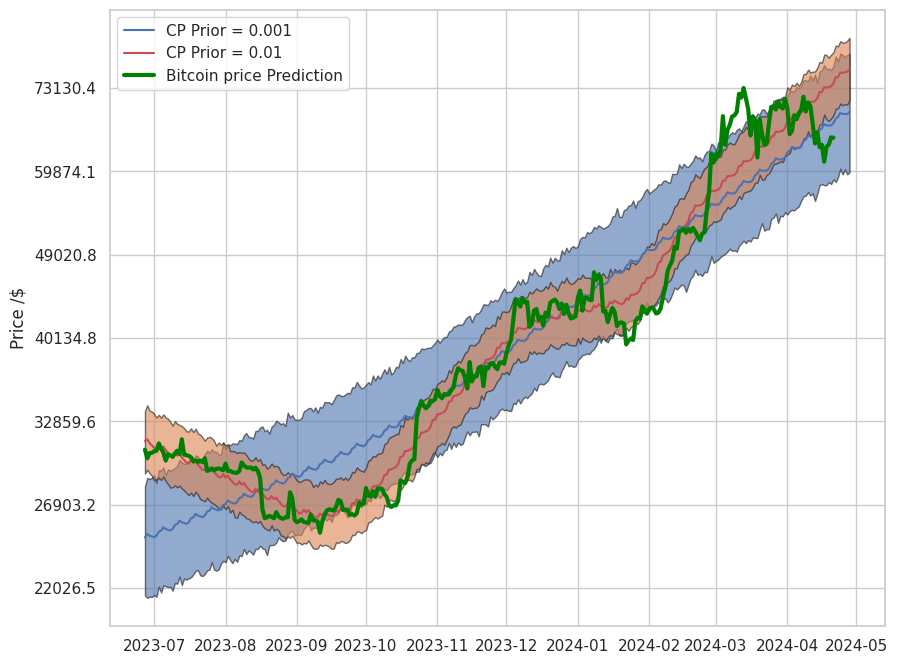

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(output.index, output["yhat_x"], label=labels[0])
ax.fill_between(output.index, output["yhat_upper_x"], output["yhat_lower_x"], alpha=0.6, edgecolor = "k")
ax.plot(output.index, output["yhat_y"], "r", label=labels[1])
ax.fill_between(output.index, output["yhat_upper_y"], output["yhat_lower_y"], alpha=0.6, edgecolor = "k")
ax.plot(data_final.ds, data_final.y, color="green", linewidth=3, label=r"Bitcoin price Prediction")
a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
plt.legend(loc="upper left")
plt.ylabel(r"Price /$")
plt.show()

# Future Enchancements

* Include more moving average features.
* Include the timeseries implementation with historical data.
* Deep Learning LSTM time series analysis.
* Streaming implementation using API call using Kafka or pub-sub mechanism.
* Real time or near real time model prediction based on SparkML timeseries implementation.

# References

* https://www.projectpro.io/recipes/read-and-write-parquet-files-pyspark
* https://api-docs.databricks.com/python/pyspark/latest/index.html
* https://www.databricks.com/blog/2020/01/27/time-series-forecasting-prophet-spark.html
* https://www.statsmodels.org/dev/index.html
* https://towardsdatascience.com/bitcoin-predictive-price-modeling-with-facebooks-prophet-b66efd0169a0
* https://github.com/facebook/prophet
* https://www.kaggle.com/code/sandeepanmukherjee/pyspark-bitcoin-trend-analysis#Building-A-Machine-Learning-Model-With-Spark-ML
